### Classifier model to predict what are the cases of heart attack ie. factors that can higher the risk of having a heart attack


In [85]:
!pip install xgboost scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.1 MB/s eta 0:00:00m eta 0:00:010:00:01m


              precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.12      0.14      0.13        50

    accuracy                           0.91      1022
   macro avg       0.54      0.54      0.54      1022
weighted avg       0.91      0.91      0.91      1022

ROC-AUC Score: 0.7870576131687242
Confusion Matrix:
 [[922  50]
 [ 43   7]]


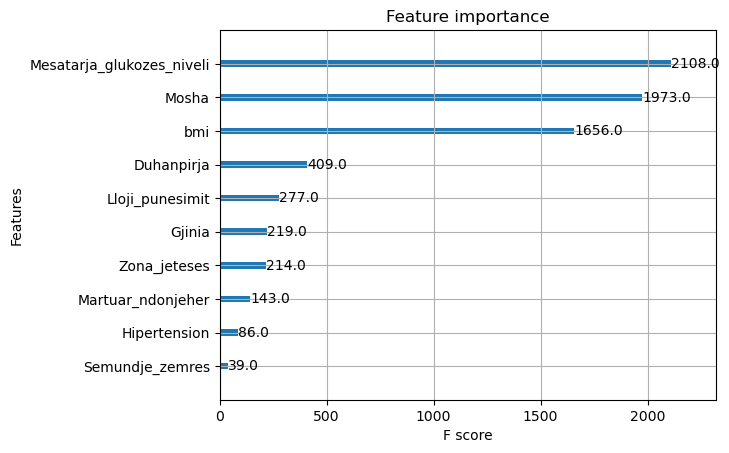

In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Load data
data = pd.read_csv('shenimet_infarktit.csv', sep="|")

# Preprocessing
# Fill missing BMI values
imputer = SimpleImputer(strategy='mean')
data['bmi'] = imputer.fit_transform(data[['bmi']])

# Encode categorical variables
label_encoders = {}
for column in ['Gjinia', 'Hipertension', 'Semundje_zemres', 'Martuar_ndonjeher', 'Lloji_punesimit', 'Zona_jeteses', 'Duhanpirja']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Features and target
X = data.drop(['ID', 'Infarkt'], axis=1)
y = data['Infarkt']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Model training with XGBoost
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1]))

# Hyperparameter tuning (optional, using GridSearchCV)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_xgb_model = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Feature Importance
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_xgb_model)
plt.savefig("GRadient_Boosting_results_prediction.png", format='png')
plt.show()
